In [1]:
#import packages needed
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import os
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

In [2]:
#functions that get each heat budget variable calculated.
#general form so can use any dataset
def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt, dTdx, dTdy, dTdz

def advection(u, v, w, dx, dy, dz):
    uadv = u*dx
    vadv = v*dy
    wadv = w*dz
    return uadv, vadv, wadv

def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1


In [3]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/*.nc').thetao
U = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc').uo
V = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/VO/*.nc').vo
#W = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/WO/*.nc').wo
Q = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/HFDS/*.nc').hfds
SW = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/RSNTDS/*.nc').rsntds
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
#W = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
#W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'lev':'level'})
U = U.rename({'lev':'level'})
V = V.rename({'lev':'level'})
#W = W.rename({'lev':'level'})

In [4]:
#calculate W term
#first get dudx and dvdy
dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
dvdy = V.differentiate(coord='lat') / (110e3)


weights = U.level#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'level': U.level},
             dims=['level'])
w_list = []
print(thickness_DA.level)


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'level')
W = w[4,:]


<xarray.DataArray 'level' (level: 5)>
array([ 5., 15., 25., 35., 45.])
Coordinates:
  * level    (level) float64 5.0 15.0 25.0 35.0 45.0
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds


In [5]:
dTdtg, dTdxg, dTdyg, dTdzg = diff_T(T)

In [6]:
uadvg, vadvg, wadvg = advection(U, V, W, dTdxg, dTdyg, dTdzg)

In [7]:
gqnet = (Q-SW*((0.67*np.exp(-50))+((1-0.67)*np.exp(-50/17))))/(3992.1*1035*50)

In [8]:
#calcualate weights of levels
weights = get_weights(T)
#now get wtd avg
dTdt_gw = weighted_avg(dTdtg, weights)
uwg = weighted_avg(uadvg, weights)
vwg = weighted_avg(vadvg, weights)
wwg = wadvg

In [9]:
#now get the year 2000 for all of these
dTdt_off=dTdt_gw.sel(time=slice('2000-01-01','2000-12-31'))
q_off=gqnet.sel(time=slice('2000-01-01','2000-12-31'))
u_off = uwg.sel(time=slice('2000-01-01','2000-12-31'))
v_off = vwg.sel(time=slice('2000-01-01','2000-12-31'))
w_off = wwg.sel(time=slice('2000-01-01','2000-12-31'))



In [10]:
#convert to w/m2
dTdt_off = dTdt_off*(3992.1*1035*50)
q_off= q_off*(3992.1*1035*50)
u_off = u_off*(3992.1*1035*50)
v_off = v_off*(3992.1*1035*50)
w_off = w_off*(3992.1*1035*50)

In [11]:
adv_off = (u_off+v_off+w_off)

In [12]:
res_off = dTdt_off-q_off+(u_off+v_off+w_off)

In [13]:
def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('st_ocean')
    return avg
def get_weights(INP):
    weights = INP.st_ocean
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'st_ocean': INP.st_ocean},
                 dims=['st_ocean'])
    return thickness_DA

In [14]:
#now load in data for online calc
dTdt_on = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*_temp_tendency').temp_tendency
dTdt_2 = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*_temp_tendency_expl').temp_tendency_expl
#net heat flux
sw= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*sw_heat').sw_heat
rvmix= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_rivermix').temp_rivermix
vdiff= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_vdiffuse_sbc').temp_vdiffuse_sbc
sfchf = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*sfc_hflux_pme').sfc_hflux_pme
q = sw+rvmix+vdiff[:,0]+sfchf

#submeso advection
tsubmeso= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_submeso').temp_submeso
#vertical mixing
tvddc= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_vdiffuse_diff_cbt').temp_vdiffuse_diff_cbt
tkpp= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_nonlocal_KPP').temp_nonlocal_KPP
vmix = tvddc+tkpp
#frazil ice formation
fraz = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*frazil_3d').frazil_3d
#parameterised along isopycnal mixing
tdvk33 = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_vdiffuse_k33').temp_vdiffuse_k33
ndt = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*neutral_diffusion_temp').neutral_diffusion_temp
pim = tdvk33+ndt
#mesoscale eddy
meso_eddy = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*neutral_gm_temp').neutral_gm_temp
#misc_misxing
mixdst= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*mixdownslope_temp').mixdownslope_temp
tsigmad= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_sigma_diff').temp_sigma_diff
tetas= xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*temp_eta_smooth').temp_eta_smooth
misc_mix = mixdst+tsigmad+tetas

In [40]:
oweights=get_weights(dTdt_on)

In [41]:
dTdt_on = weighted_avg(dTdt_on.sel(st_ocean=slice(0,50)), oweights)
dTdt_2 = weighted_avg(dTdt_2.sel(st_ocean=slice(0,50)), oweights)

q_on = weighted_avg(q.sel(st_ocean=slice(0,50)), oweights)
tsubmeso = weighted_avg(tsubmeso.sel(st_ocean=slice(0,50)), oweights)
vmix = weighted_avg(vmix.sel(st_ocean=slice(0,50)), oweights)
fraz = weighted_avg(fraz.sel(st_ocean=slice(0,50)), oweights)
pim = weighted_avg(pim.sel(st_ocean=slice(0,50)), oweights)
meso_eddy = weighted_avg(meso_eddy.sel(st_ocean=slice(0,50)), oweights)
misc_mix = weighted_avg(misc_mix.sel(st_ocean=slice(0,50)), oweights)

In [42]:
res = tsubmeso+vmix+fraz+pim+meso_eddy+misc_mix

In [19]:
adv_on = xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*_temp_advection').temp_advection


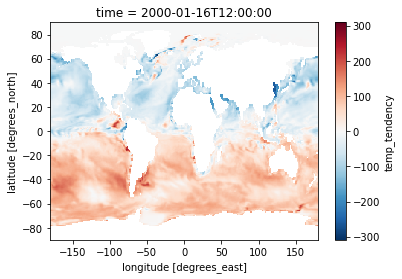

In [46]:
(4.5*dTdt_on[0]).plot()

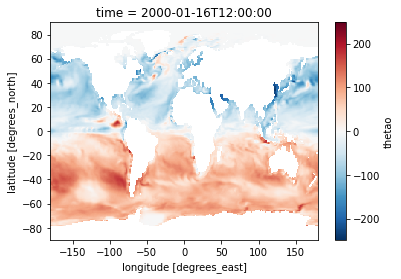

In [44]:
(dTdt_off)[0].plot()

In [90]:
#loa in temp
T_on = (xr.open_mfdataset('/home/z5113258/Documents/data/ACCESS_HB/ocean_month.nc-*_temp').temp - 273.15)
dTdt = T_on.differentiate(coord = 'time', datetime_unit= 's')
tester = T_on.diff(dim = 'time') / 2.628e+6

In [91]:
dTdt[:,0:5]

<xarray.DataArray 'temp' (time: 12, st_ocean: 5, lat: 180, lon: 360)>
dask.array<getitem, shape=(12, 5, 180, 360), dtype=float32, chunksize=(6, 5, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 45.0

In [92]:
dTdt_man_on = weighted_avg(dTdt[:,0:5], oweights)*(3992.1*1035*50)
tester = weighted_avg(tester[:,0:5], oweights)*(3992.1*1035*50)

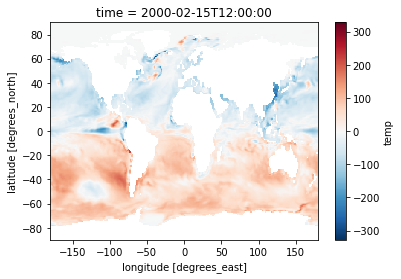

In [93]:
(tester[0]).plot()

Text(0.5, 1.0, 'temp tendency from online Temp term (sep 2000)')

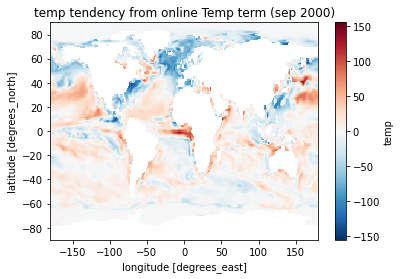

In [137]:
(dTdt_man_on[8]).plot()
plt.title('temp tendency from online Temp term (sep 2000)')

Text(0.5, 1.0, 'Temp tendency online (sep 2000)')

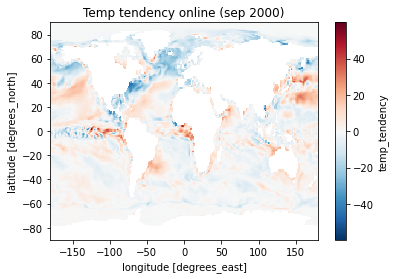

In [127]:
dTdt_on[8].plot()
plt.title('Temp tendency online (sep 2000)')

Text(0.5, 1.0, 'Temp tendency offline (sep 2000)')

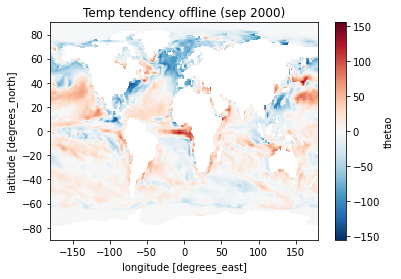

In [128]:
dTdt_off[8].plot()
plt.title('Temp tendency offline (sep 2000)')

Text(0.5, 1.0, 'online-offline temp tendency (sep 2000)')

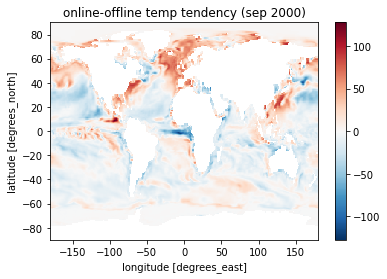

In [141]:
(dTdt_on-dTdt_off)[8].plot()
plt.title('online-offline temp tendency (sep 2000)')

Text(0.5, 1.0, 'Qnet online (sep 2000)')

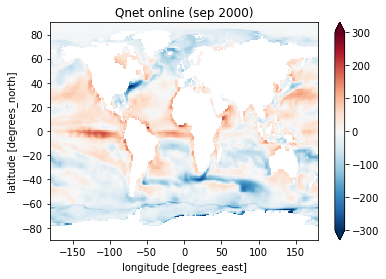

In [136]:
q_on[8].plot(vmin = -300, vmax = 300, cmap = 'RdBu_r')
plt.title('Qnet online (sep 2000)')

Text(0.5, 1.0, 'Qnet offline (sep 2000)')

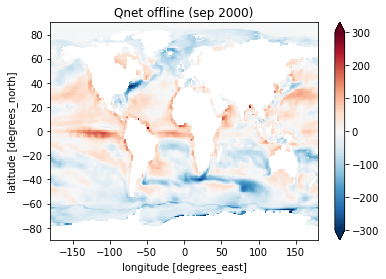

In [135]:
q_off[8].plot(vmin = -300, vmax = 300, cmap = 'RdBu_r')
plt.title('Qnet offline (sep 2000)')

Text(0.5, 1.0, 'qnet diff (on-off) (sep 2000)')

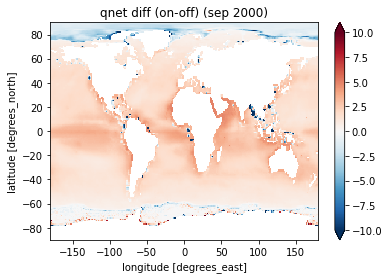

In [146]:
(q_on-q_off)[8].plot(vmin = -10, vmax = 10, cmap = 'RdBu_r')
plt.title('qnet diff (on-off) (sep 2000)')

Text(0.5, 1.0, 'residual online (sep 2000)')

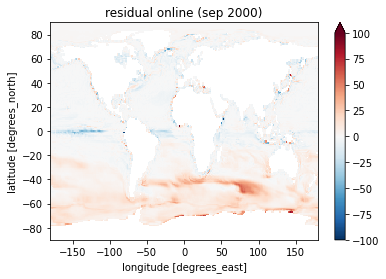

In [140]:
res[8].plot(vmin = -100, vmax = 100, cmap = 'RdBu_r')
plt.title('residual online (sep 2000)')

Text(0.5, 1.0, 'residual offline (sep 2000)')

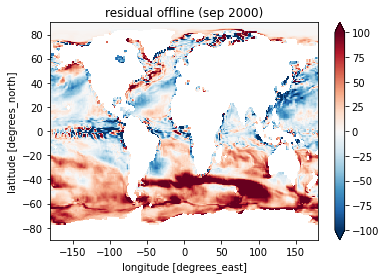

In [139]:
res_off[8].plot(vmin = -100, vmax = 100, cmap = 'RdBu_r')
plt.title('residual offline (sep 2000)')

In [100]:
#what woudd advection be if the dtdton term is correct
adv_on = q_on + res - dTdt_on
adv_man_on = q_on + res - dTdt_man_on


Text(0.5, 1.0, 'advection online (sep 2000)')

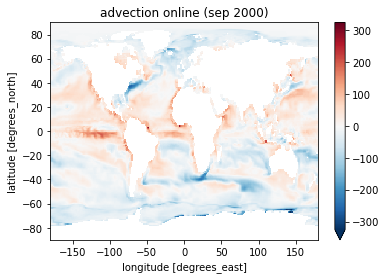

In [151]:
adv_on[8].plot(vmin = -325, vmax = 325, cmap = 'RdBu_r')
plt.title('advection online (sep 2000)')

Text(0.5, 1.0, 'advection offline (sep 2000)')

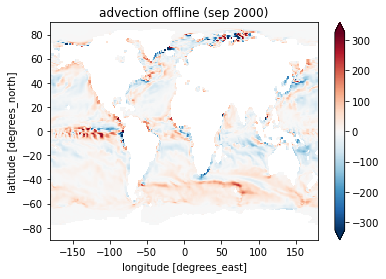

In [152]:
adv_off[8].plot(vmin = -325, vmax = 325, cmap = 'RdBu_r')
plt.title('advection offline (sep 2000)')

Text(0.5, 1.0, 'advection difference')

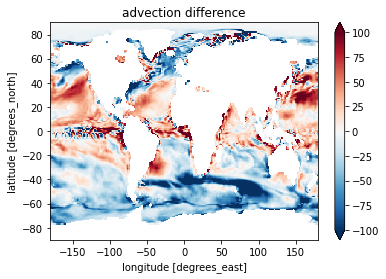

In [156]:
(adv_on - adv_off)[8].plot(vmin = -100, vmax = 100, cmap = 'RdBu_r')
plt.title('advection difference')

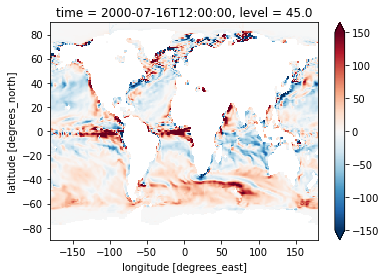

In [122]:
adv_off[6].plot(vmin = -150, vmax = 150, cmap = 'RdBu_r')